In [1]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t
from statsmodels.stats.proportion import proportions_ztest

In [2]:
df = pd.read_csv('dataset/weatherHistory.csv')

df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)

# Clean data

In [3]:
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Cloud Cover,Pressure (millibars),Daily Summary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [4]:
df = df.drop_duplicates()
df = df.dropna()

# Phân loại cột

In [5]:
qualitative_cols = ['Summary', 'Precip Type']
quantitative_cols = [
    'Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
    'Wind Speed (km/h)', 'Wind Bearing (degrees)',
    'Visibility (km)', 'Pressure (millibars)'
]

# Boxplot (phát hiện ngoại lai)

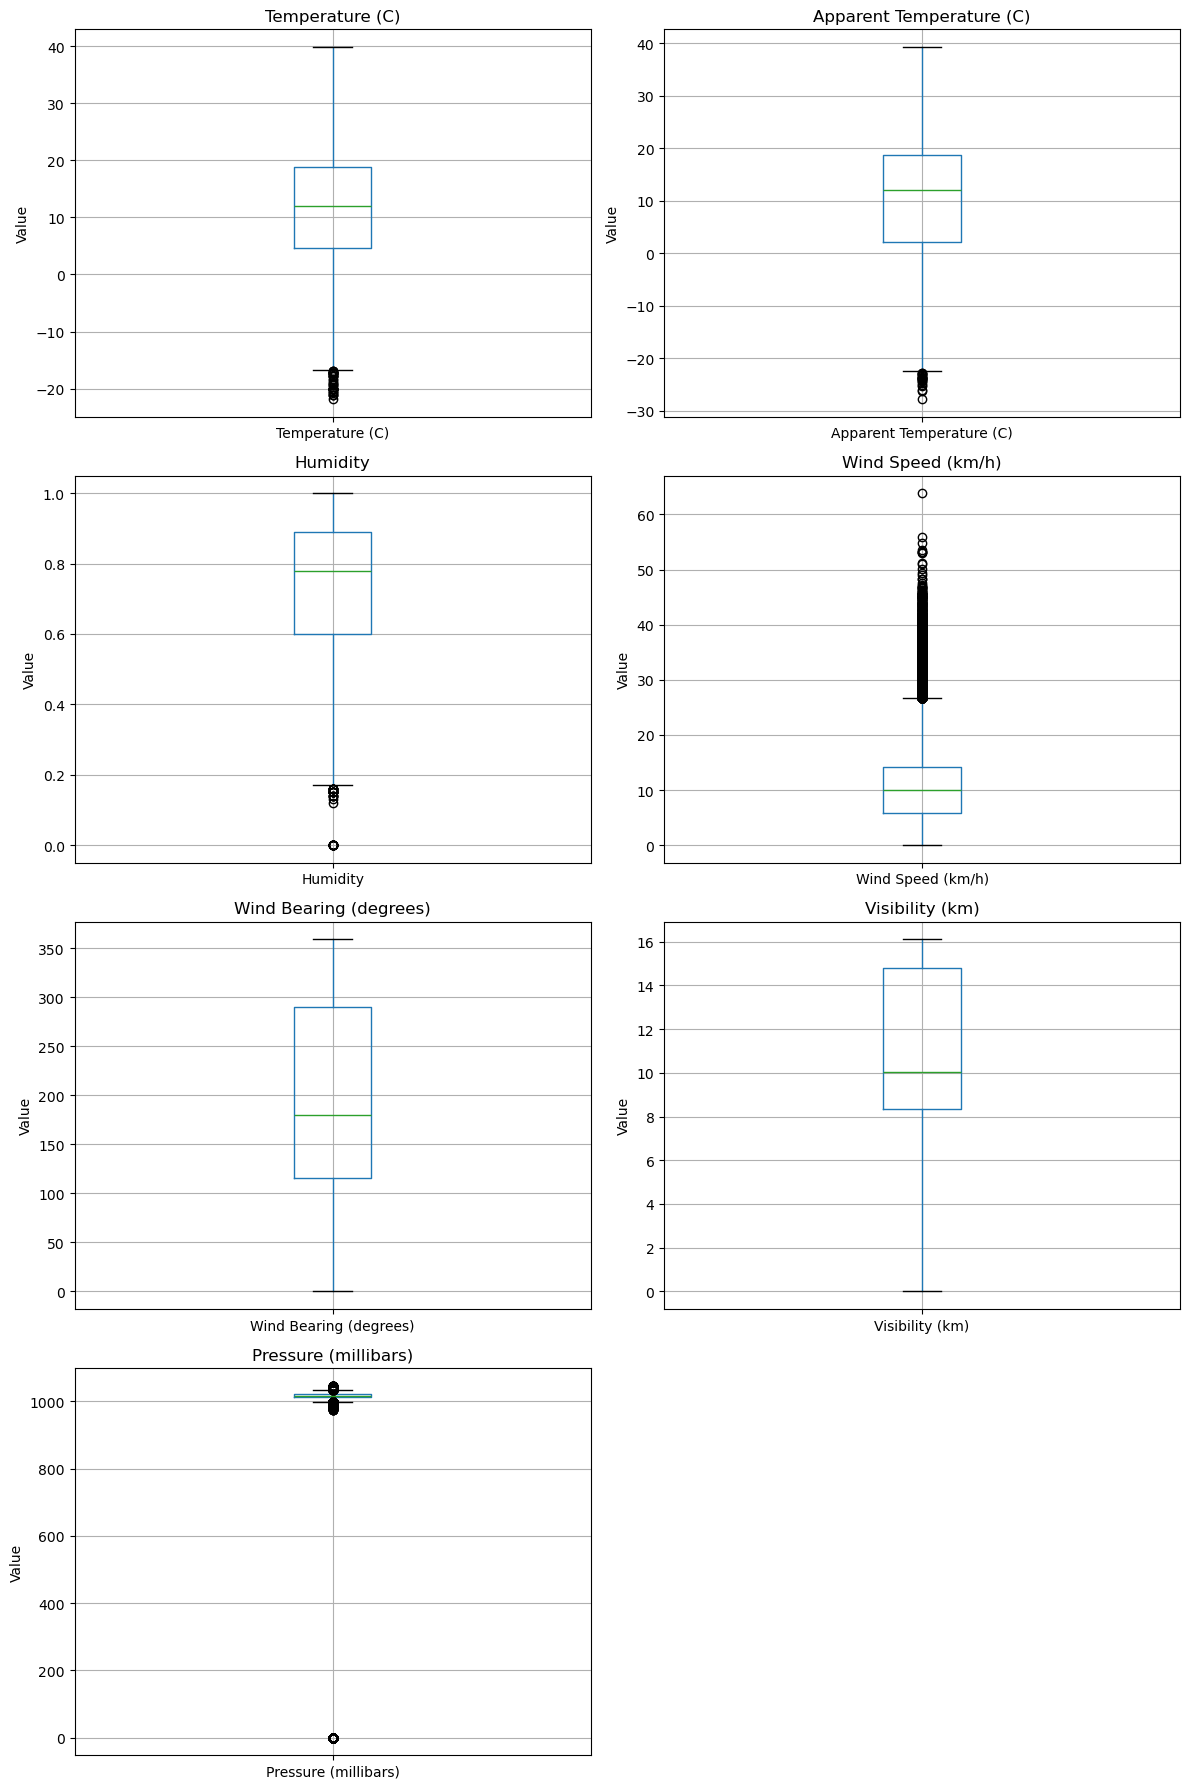

In [6]:
plt.figure(figsize=(12, 18))  
for i, col in enumerate(quantitative_cols, 1):
    plt.subplot(4, 2, i) 
    df.boxplot(column=col)
    plt.title(col)
    plt.ylabel('Value')

plt.tight_layout()
plt.savefig('figs/outliers.png')
plt.show()

# IQR Outlier Detection Function

In [7]:
def detect_outliers_iqr(data, cols):
    outlier_count = 0
    filtered_df = data.copy()
    for col in cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        mask = (data[col] >= lower) & (data[col] <= upper)
        outliers = len(data) - mask.sum()
        outlier_count += outliers
        filtered_df = filtered_df[mask]
        print(f'{col}: {outliers} outliers detected')
        
    print(f'Total outliers detected: {outlier_count}')
    return filtered_df

In [8]:
df = detect_outliers_iqr(df, quantitative_cols)

Temperature (C): 39 outliers detected
Apparent Temperature (C): 22 outliers detected
Humidity: 46 outliers detected
Wind Speed (km/h): 3011 outliers detected
Wind Bearing (degrees): 0 outliers detected
Visibility (km): 0 outliers detected
Pressure (millibars): 4423 outliers detected
Total outliers detected: 7541


C:\Users\quock\AppData\Local\Temp\ipykernel_1892\1161695731.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[mask]
C:\Users\quock\AppData\Local\Temp\ipykernel_1892\1161695731.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[mask]
C:\Users\quock\AppData\Local\Temp\ipykernel_1892\1161695731.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[mask]
C:\Users\quock\AppData\Local\Temp\ipykernel_1892\1161695731.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[mask]
C:\Users\quock\AppData\Local\Temp\ipykernel_1892\1161695731.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[mask]
C:\Users\quock\AppData\Local\Temp\ipykernel_1892\1161695731.py:13: UserWarning: Boolean Series key will be reindexe

# I. DỮ LIỆU ĐỊNH TÍNH (Qualitative Data)

               Count  Proportion (%)
Partly Cloudy  30739           34.65
Mostly Cloudy  26704           30.10
Overcast       15044           16.96
Clear           9635           10.86
Foggy           6312            7.11
Other            287            0.32


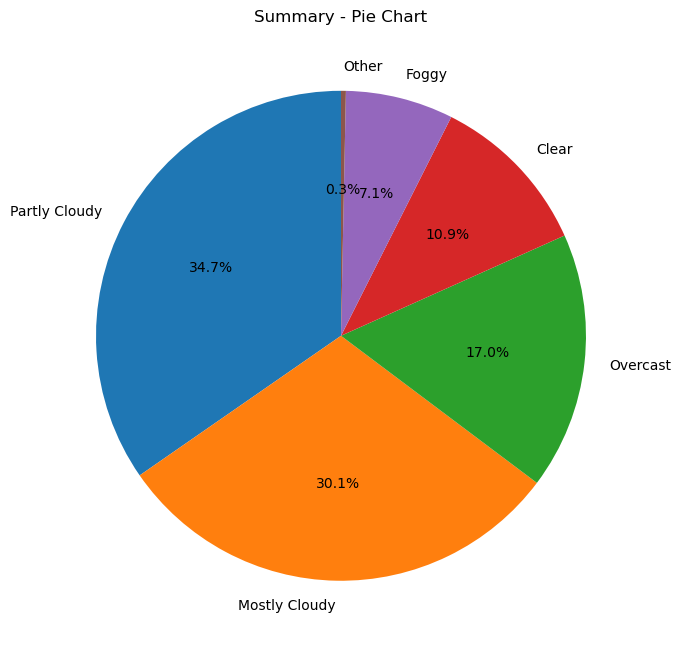

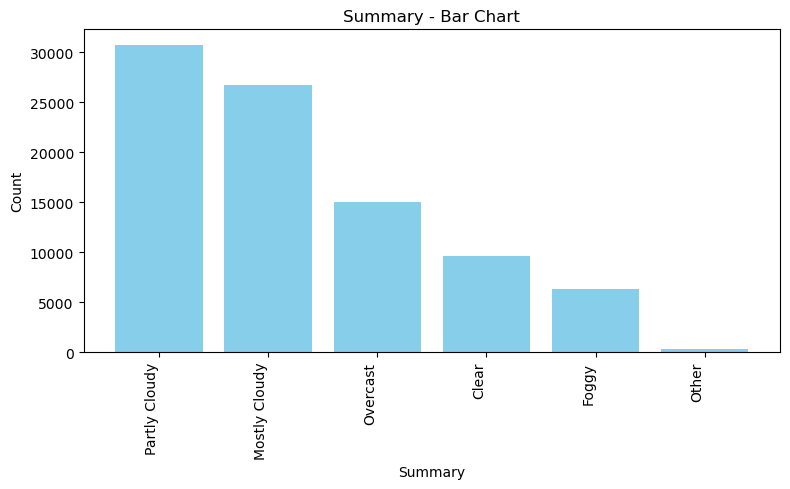

             Count  Proportion (%)
Precip Type                       
rain         79772           89.91
snow          8949           10.09


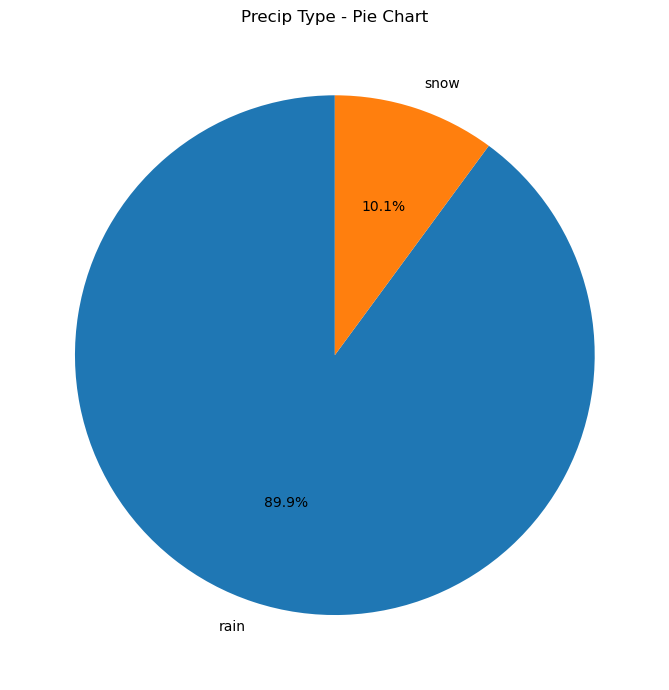

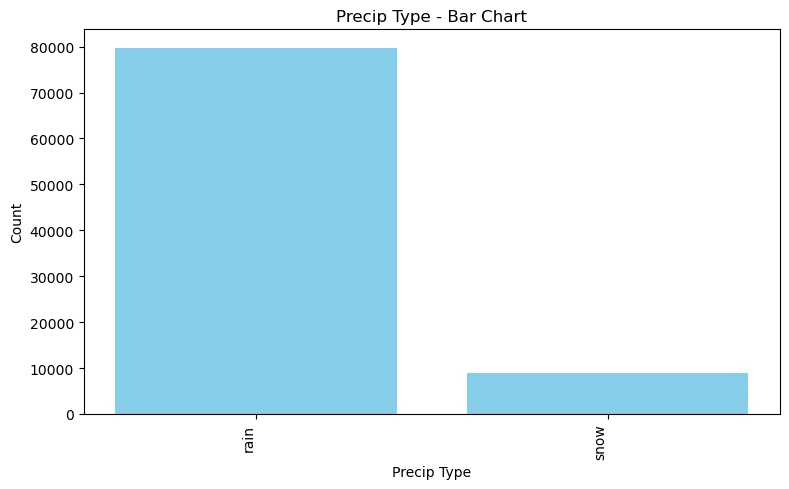

In [9]:
THRESHOLD = 1  

for col in qualitative_cols:
    freq = df[col].value_counts(dropna=False)
    rel_freq = df[col].value_counts(normalize=True, dropna=False) * 100

    freq_table = pd.DataFrame({'Count': freq, 'Proportion (%)': rel_freq.round(2)})

    small_groups = freq_table[freq_table['Proportion (%)'] < THRESHOLD]
    large_groups = freq_table[freq_table['Proportion (%)'] >= THRESHOLD]

    if not small_groups.empty:
        other_row = pd.DataFrame({
            'Count': [small_groups['Count'].sum()],
            'Proportion (%)': [small_groups['Proportion (%)'].sum()]
        }, index=['Other'])
        freq_table_plot = pd.concat([large_groups, other_row])
    else:
        freq_table_plot = freq_table

    print(freq_table_plot)

    plt.figure(figsize=(7, 7))
    plt.pie(
        freq_table_plot['Proportion (%)'],
        labels=freq_table_plot.index,
        autopct='%1.1f%%',
        startangle=90,
    )
    plt.title(f'{col} - Pie Chart')
    plt.ylabel('')
    plt.tight_layout()
    plt.savefig(f'figs/pie_{col}.png')
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.bar(
        freq_table_plot.index,
        freq_table_plot['Count'],
        color='skyblue'
    )
    plt.title(f'{col} - Bar Chart')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.savefig(f'figs/bar_{col}.png')
    plt.show()


# II. DỮ LIỆU ĐỊNH LƯỢNG (Quantitative Data)

## 2.1 Thống kê toán học cơ bản

In [10]:
df[quantitative_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature (C),88721.0,12.372417,9.471393,-16.705556,5.000000,12.316667,19.027778,38.983333
Apparent Temperature (C),88721.0,11.390042,10.564431,-22.416667,2.927778,12.316667,19.027778,39.344444
Humidity,88721.0,0.734340,0.196149,0.170000,0.600000,0.780000,0.900000,1.000000
Wind Speed (km/h),88721.0,10.141745,5.838407,0.000000,5.570600,9.660000,13.829900,26.613300
Wind Bearing (degrees),88721.0,186.551831,107.268233,0.000000,113.000000,180.000000,289.000000,359.000000
Visibility (km),88721.0,10.474333,4.151230,0.000000,8.887200,10.046400,14.908600,16.100000
Pressure (millibars),88721.0,1016.758991,6.742873,998.170000,1012.330000,1016.550000,1020.900000,1034.790000


# 2️.2 Histogram (Cutpoint Grouping)

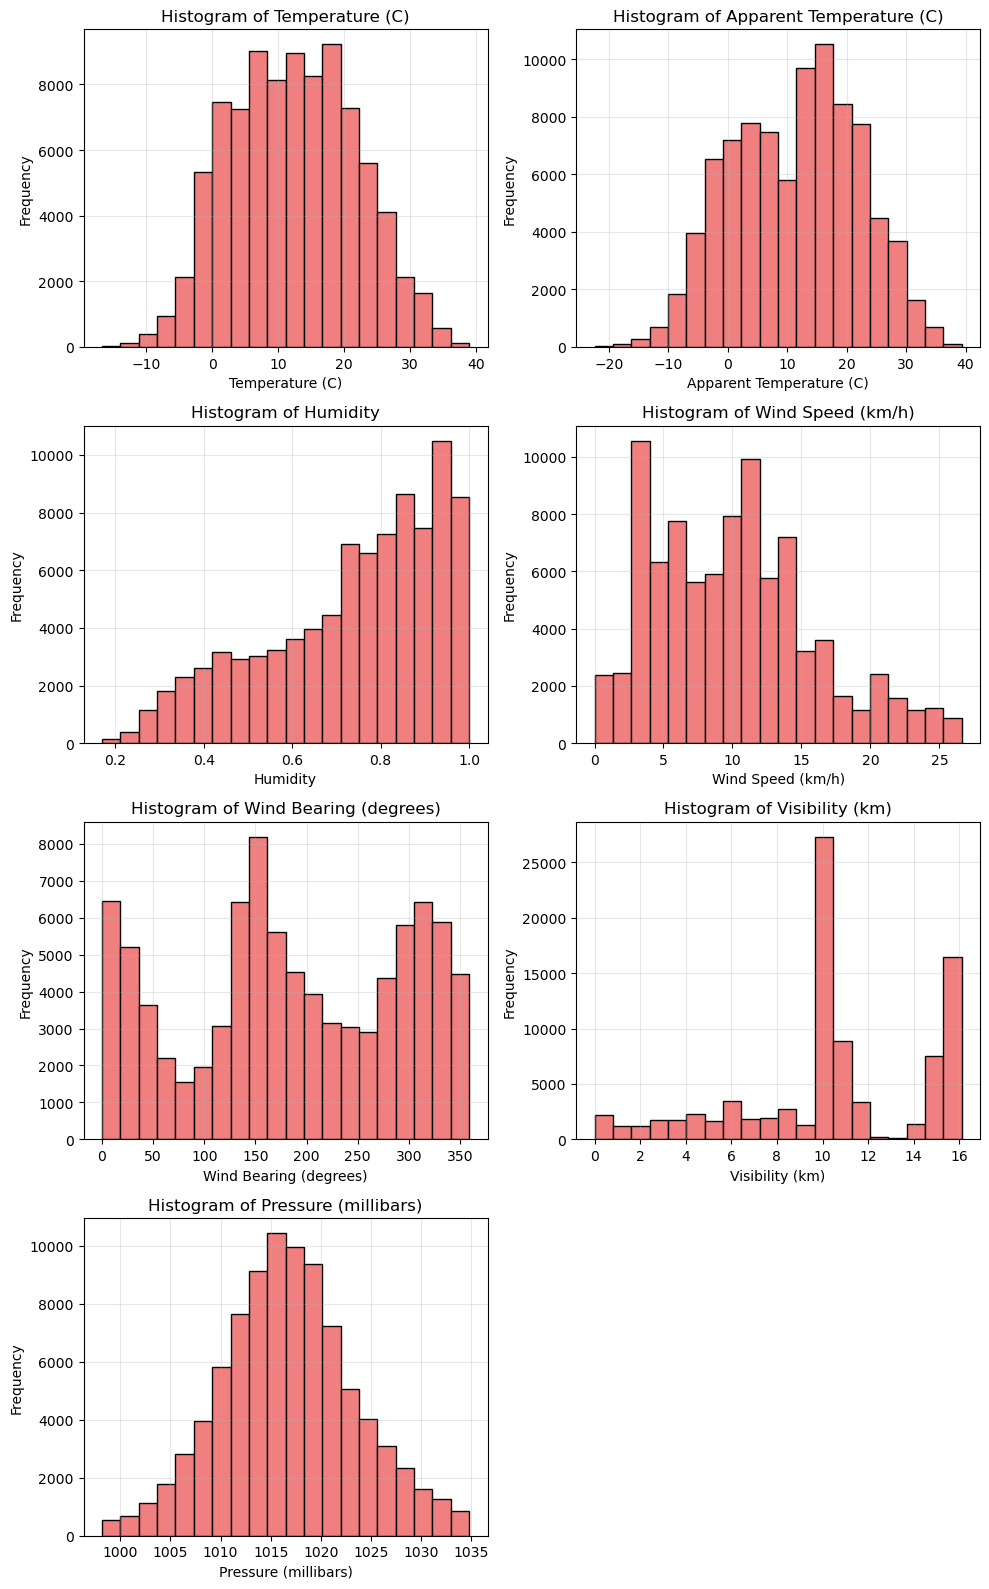

In [11]:
n = len(quantitative_cols)
rows = math.ceil(n / 2)

fig, axes = plt.subplots(rows, 2, figsize=(10, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(quantitative_cols):
    axes[i].hist(df[col].dropna(), bins=20, color='lightcoral', edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(alpha=0.3)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('figs/hist.png')
plt.show()

## 2.5 Heatmap tương quan

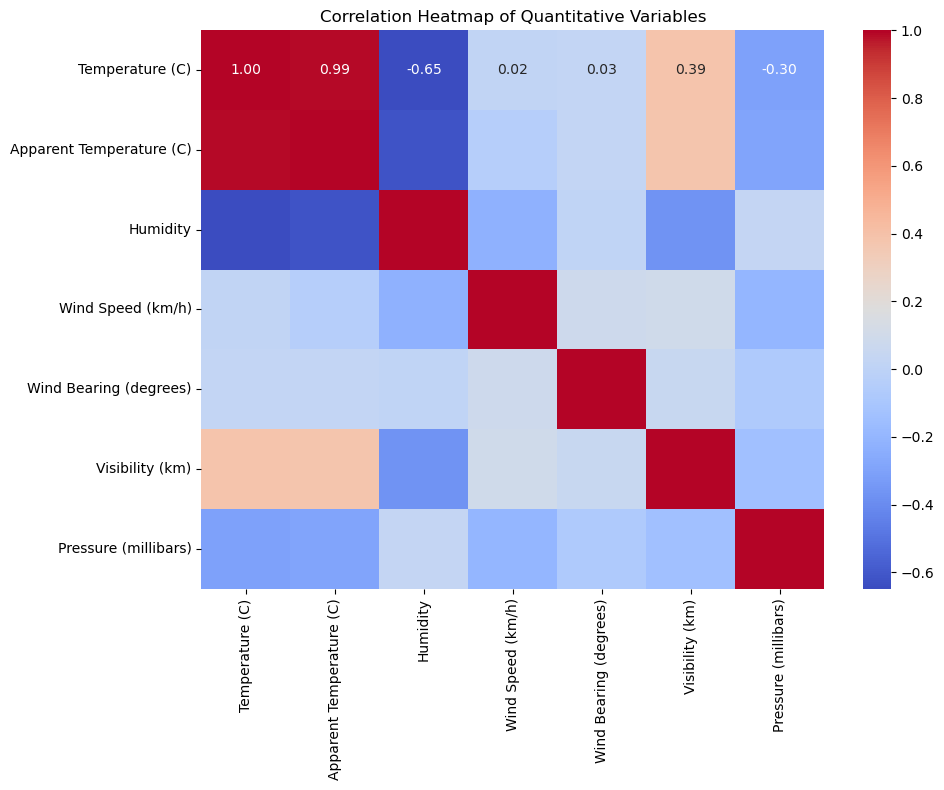

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[quantitative_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Quantitative Variables')
plt.tight_layout()
plt.savefig('figs/heatmap.png')
plt.show()

# 3. Kiểm định giả thuyết một biến mẫu

In [13]:
confidence_level = 0.95        # 95% CI
alpha = 1 - confidence_level   # 0.05
ppf_input = 1 - alpha / 2      # 0.975

t_crit = t.ppf(ppf_input, df=n-1)
z_crit = norm.ppf(ppf_input)

## 3.1 "Nhiệt độ trung bình mùa hè có khác 20°C hay không?"

In [14]:
summer_df = df[df['Formatted Date'].dt.month.isin([6, 7, 8])]
temps_summer = summer_df['Temperature (C)']

t_stat, p_two_tailed = stats.ttest_1samp(temps_summer, 20)

mean_temp = temps_summer.mean()
std_temp = temps_summer.std(ddof=1)

n = len(temps_summer)
se = std_temp / np.sqrt(n)

ci_lower = mean_temp - t_crit * se
ci_upper = mean_temp + t_crit * se


print(f"t-statistic = {t_stat:.3f}, two-tailed p-value = {p_two_tailed:.3f}")
print(f"{confidence_level * 100}% confidence interval for summer mean temperature: ({ci_lower:.3f}, {ci_upper:.3f})\n")

t-statistic = 52.845, two-tailed p-value = 0.000
95.0% confidence interval for summer mean temperature: (21.900, 22.085)



## 3.2 Tỷ lệ ngày có tuyết trong mùa đông có vượt quá 37.4% hay không.

In [15]:
value = 0.374

winter_df = df[df['Formatted Date'].dt.month.isin([12, 1, 2])]
n_total = len(winter_df)
n_snow = (winter_df['Precip Type'] == 'snow').sum()

count = n_snow
nobs = n_total

stat, p_two_tailed = proportions_ztest(count, nobs, value)
p_one_tailed = p_two_tailed / 2 if stat > 0 else 1 - (p_two_tailed / 2)

p_hat = n_snow / n_total
se_diff = np.sqrt(p_hat * (1 - p_hat) / n_total)

ci_lower = p_hat - z_crit * se_diff
ci_upper = p_hat + z_crit * se_diff

print(f"Sample proportion of snowy days in winter: {p_hat:.3f}")
print(f"z-statistic = {stat:.3f}, one-tailed p-value = {p_one_tailed:.3f}")
print(f"{confidence_level * 100}% confidence interval for proportion of snowy days in winter: ({ci_lower:.3f}, {ci_upper:.3f})")

Sample proportion of snowy days in winter: 0.368
z-statistic = -1.872, one-tailed p-value = 0.969
95.0% confidence interval for proportion of snowy days in winter: (0.361, 0.374)


# 4. Kiểm định giả thuyết hai biến mẫu

## 4.1. "Nhiệt độ trung bình trong ngày “Mostly Cloudy” có cao hơn so với “Partly Cloudy” hay không?"

In [16]:
mostly_cloudy = df[df['Summary'] == 'Mostly Cloudy']['Temperature (C)']
partly_cloudy = df[df['Summary'] == 'Partly Cloudy']['Temperature (C)']

t_stat, p_two_tailed = stats.ttest_ind(mostly_cloudy, partly_cloudy, equal_var=True)

p_one_tailed = p_two_tailed / 2 if t_stat > 0 else 1 - (p_two_tailed / 2)

n1, n2 = len(mostly_cloudy), len(partly_cloudy)
mean1, mean2 = mostly_cloudy.mean(), partly_cloudy.mean()
std1, std2 = mostly_cloudy.std(ddof=1), partly_cloudy.std(ddof=1)
s_pooled = np.sqrt(((n1-1)*std1**2 + (n2-1)*std2**2) / (n1+n2-2))
se_diff = s_pooled * np.sqrt(1/n1 + 1/n2)

dfree = n1 + n2 - 2
ci_lower = (mean1 - mean2) - t_crit * se_diff
ci_upper = (mean1 - mean2) + t_crit * se_diff

print(f"t-statistic = {t_stat:.3f}")
print(f"one-tailed p-value = {p_one_tailed:.3f}")
print(f"{confidence_level * 100}% CI for difference (Mostly - Partly) = ({ci_lower:.3f}, {ci_upper:.3f})")
print(f"Mean Mostly Cloudy = {mean1:.2f}, Mean Partly Cloudy = {mean2:.2f}")

t-statistic = -45.223
one-tailed p-value = 1.000
95.0% CI for difference (Mostly - Partly) = (-3.562, -3.197)
Mean Mostly Cloudy = 12.85, Mean Partly Cloudy = 16.23


## 4.2. Tỷ lệ mưa trong các ngày “Mostly Cloudy” có khác so với “Partly Cloudy” hay không.

In [17]:
mostly_cloudy = df[df['Summary'] == 'Mostly Cloudy']
partly_cloudy = df[df['Summary'] == 'Partly Cloudy']

count1 = (mostly_cloudy['Precip Type'] == 'rain').sum()
nobs1 = len(mostly_cloudy)

count2 = (partly_cloudy['Precip Type'] == 'rain').sum()
nobs2 = len(partly_cloudy)

count = np.array([count1, count2])
nobs = np.array([nobs1, nobs2])

stat, p_two_tailed = proportions_ztest(count, nobs)
p_value = p_two_tailed  

p1_hat = count1 / nobs1
p2_hat = count2 / nobs2
diff = p1_hat - p2_hat

se_diff = np.sqrt(p1_hat*(1-p1_hat)/nobs1 + p2_hat*(1-p2_hat)/nobs2)

ci_lower = diff - z_crit * se_diff
ci_upper = diff + z_crit * se_diff

print(f"Proportion Mostly Cloudy = {p1_hat:.3f}, Partly Cloudy = {p2_hat:.3f}")
print(f"z-statistic = {stat:.3f}, two-tailed p-value = {p_value:.3f}")
print(f"{confidence_level * 100}% CI for difference (Mostly - Partly) = ({ci_lower:.3f}, {ci_upper:.3f})")

Proportion Mostly Cloudy = 0.937, Partly Cloudy = 0.951
z-statistic = -7.125, two-tailed p-value = 0.000
95.0% CI for difference (Mostly - Partly) = (-0.017, -0.010)
